In [73]:
import numpy as np

from epsie import proposals, samplers

%matplotlib notebook
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

from empiricalgalo import utils


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Warning

This tutorial is not cleaned up for a clear use.

In [69]:
def calculate_acf(data):
    """Calculates the autocorrelation of some data"""
    # zero the mean
    data = data - data.mean()
    # zero-pad to 2 * nearest power of 2
    newlen = int(2**(1+np.ceil(np.log2(len(data)))))
    x = np.zeros(newlen)
    x[:len(data)] = data[:]
    # correlate
    acf = np.correlate(x, x, mode='full')
    # drop corrupted region
    acf = acf[len(acf)//2:]
    # normalize
    acf /= acf[0]
    return acf

def calculate_acl(data):
    """Calculates the autocorrelation length of some data.
    
    Algorithm used is from:
    N. Madras and A.D. Sokal, J. Stat. Phys. 50, 109 (1988).
    """
    # calculate the acf
    acf = calculate_acf(data)
    # now the ACL: Following from Sokal, this is estimated
    # as the first point where M*tau[k] <= k, where
    # tau = 2*cumsum(acf) - 1, and M is a tuneable parameter,
    # generally chosen to be = 5 (which we use here)
    m = 5
    cacf = 2.*np.cumsum(acf) - 1.
    win = m * cacf <= np.arange(len(cacf))
    if win.any():
        acl = int(np.ceil(cacf[np.where(win)[0][0]]))
    else:
        # data is too short to estimate the ACL, just choose
        # the length of the data
        acl = len(data)
    return acl


def thinned_arrays(sampler):
    # get the samples; recall that this is a dictionary of 
    # nchains x niterations arrays for each parameter
    samples = sampler.positions
    # as we said above, we'll assume the first half
    # of the chain was burn in
    burnin_iter = sampler.niterations // 2
    # set up arrays to store the ACL of each chain and
    # the thinned chains
    acls = np.zeros(nchains, dtype=int)
    thinned_arrays = {'mu': [], 'std': []}
    # cycle over the chains, calculating the ACLs and thinning them
    for ii in range(nchains):
        # get the second half of the chains
        sx = samples['mu'][ii, burnin_iter:]
        sy = samples['std'][ii, burnin_iter:]
        # compute the acl for each parameter
        aclx = calculate_acl(sx)
        acly = calculate_acl(sy)
        acl = max(aclx, acly)
        acls[ii] = acl
        # note that we'll thin the arrays starting from the
        # end to get the lastest results
        thinned_arrays['mu'].append(sx[::-1][::acl][::-1])
        thinned_arrays['std'].append(sy[::-1][::acl][::-1])
    thinned_arrays['mu'] = np.hstack(thinned_arrays['mu'])
    thinned_arrays['std'] = np.hstack(thinned_arrays['std'])
    return thinned_arrays

<IPython.core.display.Javascript object>


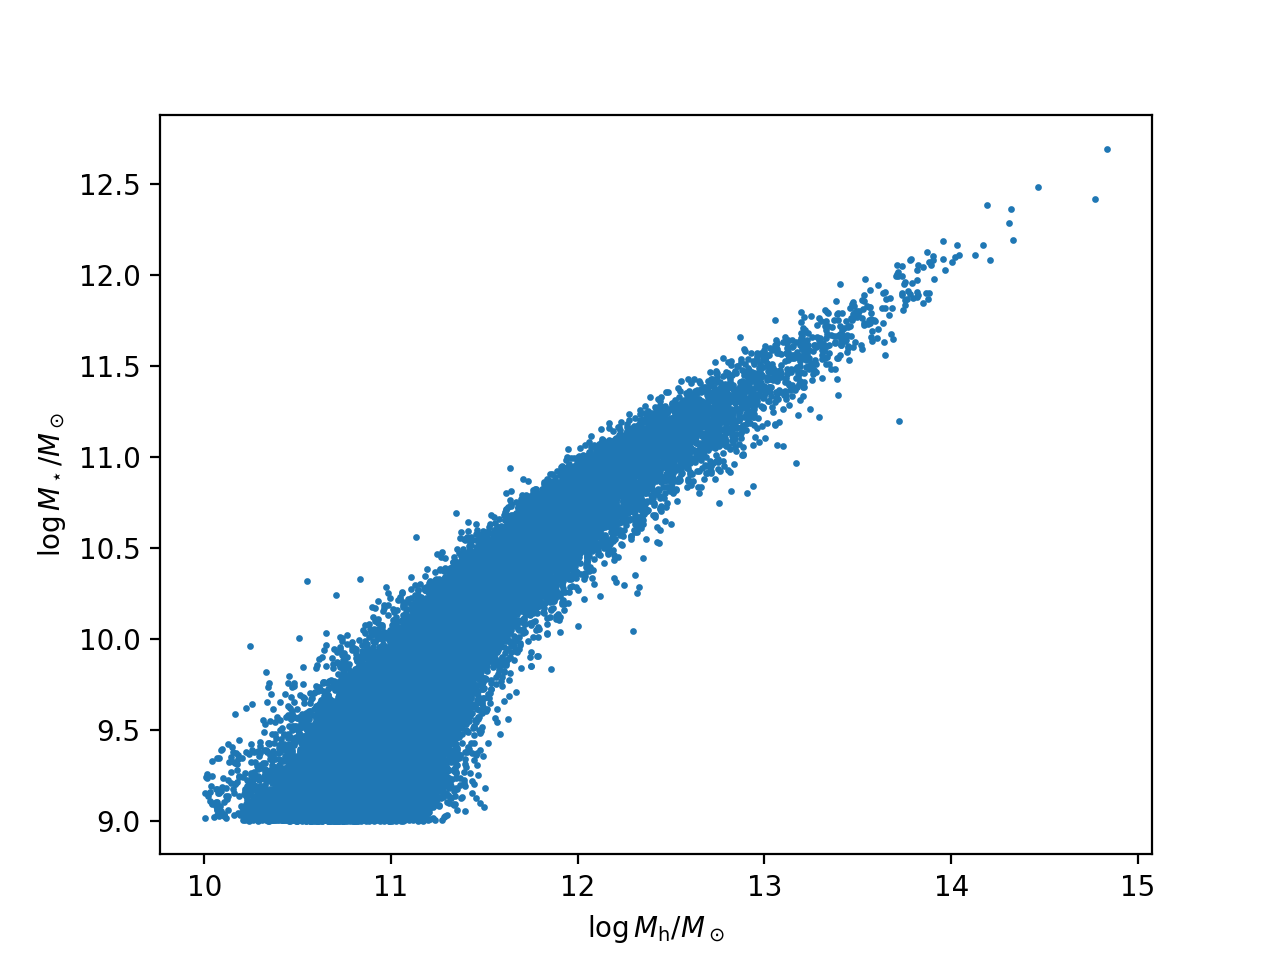

In [70]:
# load some example data
data = np.load("/Users/richard/Projects/data/HAGNmatch.npy")
mask = (data["H_level"] == 1) & (data["H_mhalo"] > 1e10) & (data["G_mgal"] > 1e9)
data = data[mask]


logMhalo = np.log10(data["H_mhalo"])
logMstar = np.log10(data["G_mgal"])

# We wish to calculate the scatter in $\log M_\star/M_\odot$ at fixed $M_{\rm h}$.
# The data looks like this
plt.figure()
plt.scatter(logMhalo, logMstar, s=2)
plt.xlabel(r"$\log M_{\rm h} / M_\odot$")
plt.ylabel(r"$\log M_\star / M_\odot$")
plt.show()

<IPython.core.display.Javascript object>


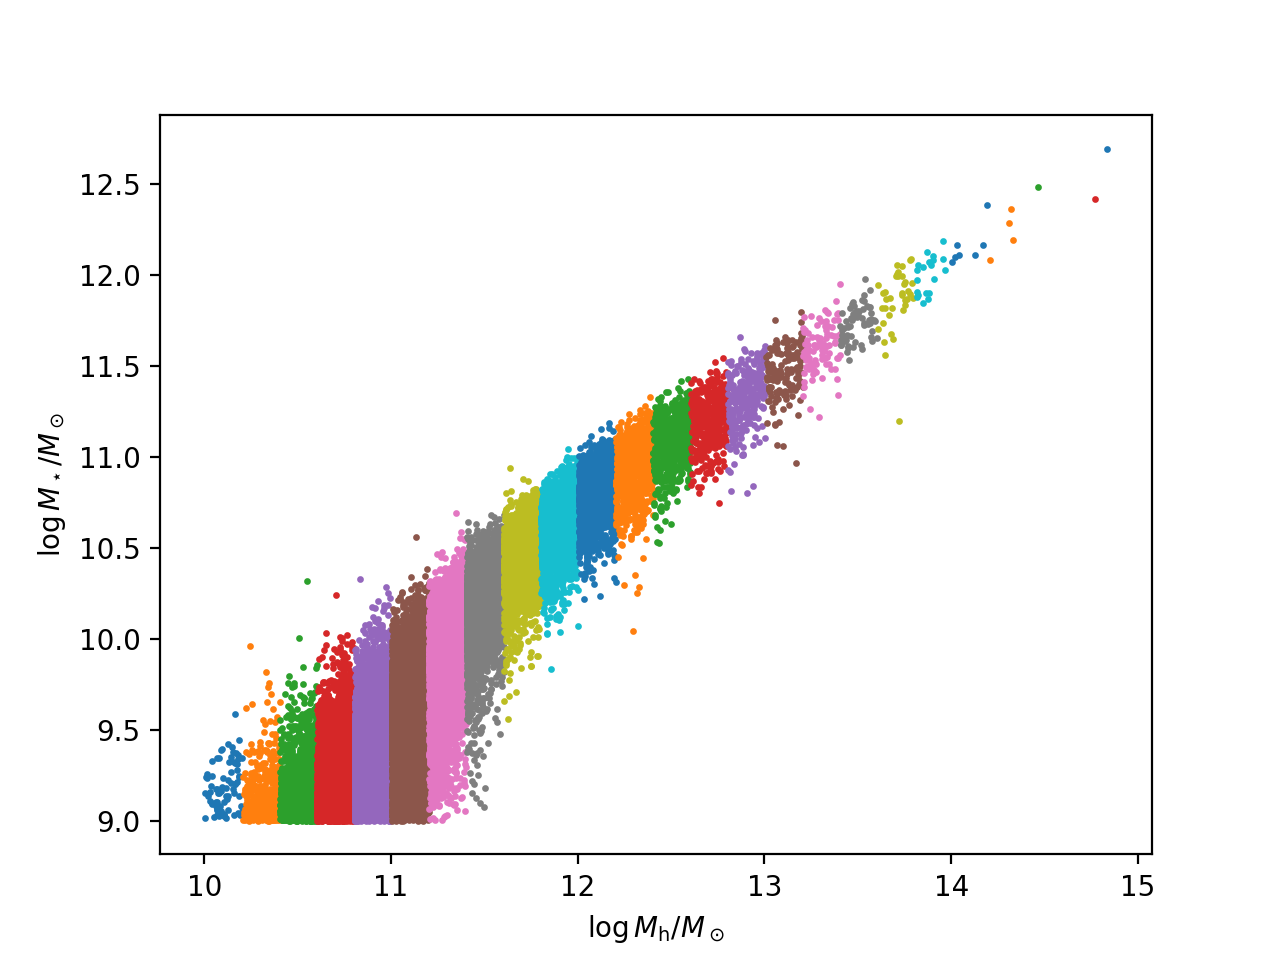

In [71]:
# Get the binning object for easy use
bins = utils.BinningAssignment(logMhalo, logMstar, 0.2)

# We can plot the binned data
plt.figure()
for i in range(bins.Nbins):
    plt.scatter(*bins(i), s=2)
plt.xlabel(r"$\log M_{\rm h} / M_\odot$")
plt.ylabel(r"$\log M_\star / M_\odot$")
plt.show()

In [79]:
def plot_chains(sampler, nchains):
    pos = sampler.positions
    x = range(sampler.niterations // 2, sampler.niterations)

    fig, axes = plt.subplots(ncols=2, figsize=(8,  3))

    for i in range(nchains):
        axes[0].plot(x, pos['mu'][i, adaptation_duration:], lw=0.2)
        axes[1].plot(x, pos['std'][i, adaptation_duration:], lw=0.2)

    axes[0].set_ylabel('mu')
    axes[1].set_ylabel('std')
    axes[0].set_xlabel('iteration')
    axes[1].set_xlabel('iteration')
    fig.show()
    
    
def process_results(sampler):
    results = thinned_arrays(sampler)
    mean_mu = np.mean(results['mu'])
    mean_std = np.mean(results['std'])
    low_std = np.percentile(results['std'], 16)
    high_std = np.percentile(results['std'], 84)
    
    return mean_mu, mean_std, low_std, high_std

In [80]:
i = 10

x, y = bins(5)

model = utils.BivariateGaussianScatterPosterior(y)

In [81]:
results = np.full((bins.Nbins, 5), fill_value=np.nan)
parameters = ["mu", "std"]
adaptation_duration = 5000
nchains = 1
# pool = multiprocessing.Pool(nchains)

# Loop over the bins
for i in [10]:
    x, y = bins(i)
    # Check we have at least one sample
    if not x.size > 1:
        continue
    model = utils.BivariateGaussianScatterPosterior(y)
    # Setup the sampler
    prop = proposals.ATAdaptiveNormal(parameters, adaptation_duration)
    sampler = samplers.MetropolisHastingsSampler(parameters, model, nchains,
                                                 proposals=[prop])
    sampler.start_position = model.prior_rvs(size=nchains)
    sampler.run(adaptation_duration * 2)
#     plot_chains(sampler, nchains)
    
    results[i, 0] = np.median(x)
    results[i, 1:] = process_results(sampler)


# results0 = deepcopy(results[~np.isnan(results[:, 0]), :])